In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# Loading the image

The shape of original image is (1024, 962, 3)



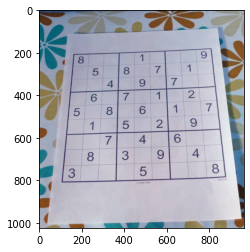

In [4]:
#cv2 reads image in BGR format, while matplotlib in RGB format
img = cv2.imread('/content/drive/MyDrive/Projects/Sudoku Solver/sudoku.jpg')
plt.imshow(img);
print('The shape of original image is {}\n'.format(img.shape))

#Preprocessing the image

### Resizing the image and creating a blank image

In [5]:
width, height = 450, 450
img = cv2.resize(img, (width, height)) #changes the shape of the image into 450x450
print('The shape of resized image is {}\n'.format(img.shape))

The shape of resized image is (450, 450, 3)



The shape of blank image is (450, 450, 3)



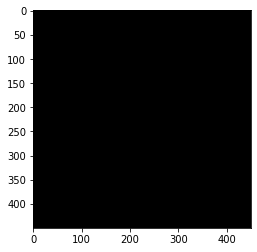

In [6]:
imgBlank = np.zeros((width, height, 3), np.uint8)  #creating a blank image of the same size as the resized image to overlay
plt.imshow(imgBlank);
print('The shape of blank image is {}\n'.format(img.shape))

### Cleaning the image

In [20]:
def preprocess(img):
  imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convet BGR to Gray
  imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)
  imgThreshold = cv2.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)
  
  # uncomment the next lines to view each image processing
  fig = plt.figure(figsize = (20, 20))
  fig.add_subplot(5,5, 1)
  plt.imshow(img)
  plt.title("Original Image")
  fig.add_subplot(5,5, 2)
  plt.imshow(imgGray, cmap = 'gray') #plt displays images using three channels, so the extra parameter is needed to display the gray image
  plt.title("Grayed")
  fig.add_subplot(5,5, 3)
  plt.imshow(imgBlur, cmap = 'gray')
  plt.title("Blurred")
  fig.add_subplot(5,5, 4)
  plt.imshow(imgThreshold, cmap = 'gray')
  plt.title("Applied Threshold")

  return imgThreshold

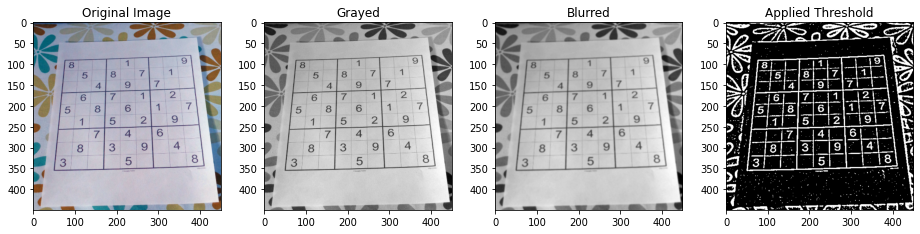

In [21]:
imgThreshold = preprocess(img)

###Finding the contours

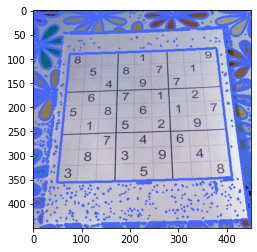

In [22]:
imgContours, imgBigContour = img.copy(), img.copy()
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgContours, contours, -1, (70,102,255), 3)
plt.imshow(imgContours);

###Finding the biggest contour

In [24]:
def biggestContourFinder(contours):
  biggest = np.array([])
  max_area = 0
  for i in contours:
    area = cv2.contourArea(i)
    if area > 50:
      perimeter = cv2.arcLength(i, True)
      approx = cv2.approxPolyDP(i, 0.02*perimeter, True)
      if area>max_area and len(approx) == 4:
        biggest = approx
        max_area = area

  # uncomment the following two lines to see the contour points
  # a = cv2.drawContours(img, biggest, -1, (255,0,0), 9)
  # plt.imshow(a, cmap = 'gray');
  
  return biggest, max_area

In [25]:
biggest, max_area = biggestContourFinder(contours)

### Finding the order of the points

In [26]:
def reorder(myPoints):
  myPoints = myPoints.reshape((4,2))
  myPointsNew = np.zeros((4,1,2), np.int32)
  add = myPoints.sum(1)
  myPointsNew[0] = myPoints[np.argmin(add)]
  myPointsNew[3] = myPoints[np.argmax(add)]
  diff = np.diff(myPoints, axis = 1)
  myPointsNew[1] = myPoints[np.argmin(diff)]
  myPointsNew[2] = myPoints[np.argmax(diff)]
  return myPointsNew

In [27]:
biggestReordered = reorder(biggest)
#print('The original points: \n{}\n\nThe reordered points: \n{}'.format(biggest, biggestReordered))

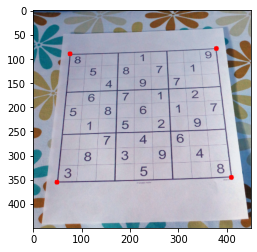

In [28]:
cv2.drawContours(imgBigContour, biggestReordered, -1, (255,0,0), 10)
plt.imshow(imgBigContour);

###Warping the image

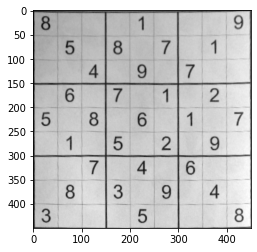

In [36]:
pts1 = np.float32(biggestReordered) 
pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
matrix = cv2.getPerspectiveTransform(pts1, pts2) #perspective matrix
imgWarpColored = cv2.warpPerspective(img, matrix, (width, height)) #applying the warp
imgWarpGray = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY) #changing to grayscale
plt.imshow(imgWarpGray, cmap = 'gray')

###Extracting the individual number boxes

In [38]:
def splitBoxes(img):
  rows = np.vsplit(img, 9)
  boxes = []
  for r in rows:
    cols = np.hsplit(r, 9)
    for box in cols:
      boxes.append(box)
  return boxes

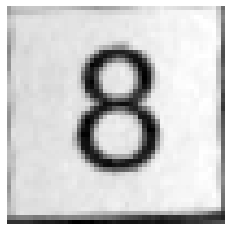

In [39]:
boxes = splitBoxes(imgWarpGray)
plt.imshow(boxes[80], cmap = 'gray')
plt.axis(False);

### Extracting Digits

In [43]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Projects/Sudoku Solver/digitClassifier.h5')
def getPredection(boxes,model):
    result = []
    for image in boxes:
        ## PREPARE IMAGE
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (28, 28))
        img = img / 255
        img = img.reshape(1, 28, 28, 1)
        ## GET PREDICTION
        predictions = model.predict(img)
        classIndex = model.predict_classes(img)
        probabilityValue = np.amax(predictions)
        ## SAVE TO RESULT
        if probabilityValue > 0.8:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result
numbers = getPredection(boxes, model)
print(numbers)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[8, 0, 0, 0, 1, 0, 0, 0, 9, 0, 0, 0, 8, 0, 0, 0, 1, 0, 0, 0, 4, 0, 9, 0, 7, 0, 0, 0, 6, 0, 7, 0, 1, 0, 2, 0, 5, 0, 8, 0, 6, 0, 1, 0, 7, 0, 1, 0, 5, 0, 2, 0, 9, 0, 0, 0, 7, 0, 4, 0, 6, 0, 0, 0, 8, 0, 3, 0, 9, 0, 4, 0, 3, 0, 0, 0, 5, 0, 0, 0, 8]


###Display Digit on Image

In [44]:
def displayNumbers(img, numbers, color = (255,0,0)):
  secW = int(img.shape[1]/9)
  secH = int(img.shape[0]/9)
  for x in range(9):
    for y in range(9):
      if numbers[(y*9)+x] != 0:
        cv2.putText(img, 
                    str(numbers[(y*9)+x]), 
                    (x*secW+int(secW/2)-10, int((y+0.8)*secH)), 
                    cv2.FONT_HERSHEY_COMPLEX_SMALL,
                    2, color, 2, cv2.LINE_AA)
  return img

In [45]:
imgDetectedDigits = imgBlank.copy()
imgDetectedDigits = displayNumbers(imgDetectedDigits, numbers, color=(255, 0, 255))
numbers = np.asarray(numbers)
posArray = np.where(numbers > 0, 0, 1)
print(posArray)

[0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1
 1 1 0 1 1 1 0]


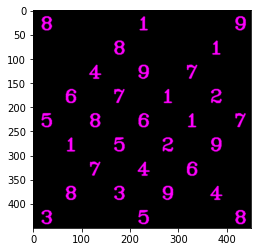

In [ ]:
plt.imshow(imgDetectedDigits);

###Finding Solution of the Board

In [47]:
board = np.array_split(numbers, 9)

In [115]:
import sudokuSolver
imgSolvedDigits = imgBlank.copy()
try:
  sudokuSolver.solve(board)
except:
  pass

flatList = []
for subList in board:
  for item in subList:
    flatList.append(item)
solvedNumbers = flatList*posArray
imgSolvedDigits = displayNumbers(imgSolvedDigits, solvedNumbers, color = (0,255,0))

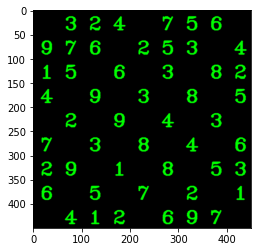

In [116]:
plt.imshow(imgSolvedDigits)

###Overlaying the Answer

In [119]:
pts2 = np.float32(biggestReordered) # PREPARE POINTS FOR WARP
pts1 =  np.float32([[0, 0],[width, 0], [0, height],[width, height]]) # PREPARE POINTS FOR WARP
matrix = cv2.getPerspectiveTransform(pts1, pts2)  # GER
imgInvWarpColored = img.copy()
imgInvWarpColored = cv2.warpPerspective(imgSolvedDigits, matrix, (width, height))
inv_perspective = cv2.addWeighted(imgInvWarpColored, 1, img, 0.9, 1)

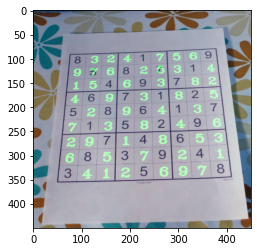

In [120]:
plt.imshow(inv_perspective);